In [2]:
import os
import json
import skimage.io
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

-----
### Prepare the config file
CRESI reads from a .json configuration file, and for a pre-trained model executing inference requires only changing a few paths (namely, the testing imagery, model weights, and results paths) in the ```cresi/cresi/configs/dar_tutorial_cpu.json``` file.  These paths should already be set properly, but if not, exectue the cell below.

In [3]:
cresi_dir = '/opt/cresi'
%cd {cresi_dir}

/opt/cresi


In [4]:
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, src_dir, 'configs')
weight_dir = os.path.join(cresi_dir, src_dir, config_dir, 'weights')

data_dir  = os.path.join(cresi_dir, 'data')
test_im_raw_dir = os.path.join(cresi_dir, data_dir, 'PS-MS')
test_im_clip_dir = os.path.join(cresi_dir, data_dir, 'clips')
test_final_dir = os.path.join(cresi_dir, data_dir, 'final_clips')

results_root_dir = os.path.join(cresi_dir, 'results')
results_dir = os.path.join(results_root_dir, 'dar_tutorial_cpu')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

# make dirs
for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir, mask_stitched_dir, mask_pred_dir]:
    os.makedirs(d, exist_ok=True)

In [5]:
config_path = os.path.join(config_dir, 'dar_tutorial_cpu.json')
print("config path:", config_path)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    
    data['path_data_root'] = os.path.join(src_dir, 'data')
    
    data['path_results_root'] = results_root_dir
    data['save_weights_dir'] = weight_dir
    
    data['test_data_refined_dir'] = test_final_dir
    
    data['test_sliced_dir'] = test_final_dir + '_sliced'
    data['test_results_dir'] = 'dar_tutorial_cpu'

config path: /opt/cresi/cresi/configs/dar_tutorial_cpu.json


In [6]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

print("config data:")
data

config data:


{'path_src': '/opt/cresi/cresi',
 'path_results_root': '/opt/cresi/results',
 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv',
 'save_weights_dir': '/opt/cresi/cresi/configs/weights',
 'test_data_refined_dir': '/opt/cresi/data/final_clips',
 'test_sliced_dir': '/opt/cresi/data/final_clips_sliced',
 'test_results_dir': 'dar_tutorial_cpu',
 'slice_x': 1300,
 'slice_y': 1300,
 'stride_x': 1280,
 'stride_y': 1280,
 'skeleton_thresh': 0.25,
 'min_subgraph_length_pix': 600,
 'min_spur_length_m': 12,
 'rdp_epsilon': 1,
 'log_to_console': 0,
 'train_data_refined_dir_ims': '',
 'train_data_refined_dir_masks': '',
 'folds_file_name': 'folds4.csv',
 'folds_save_dir': 'folds',
 'tile_df_csv': 'tile_df.csv',
 'merged_dir': 'merged',
 'stitched_dir_raw': 'stitched/mask_raw',
 'stitched_dir_count': 'stitched/mask_count',
 'stitched_dir_norm': 'stitched/mask_norm',
 'wkt_submission': 'wkt_submission_nospeed.csv',
 'skeleton_dir': 'skeleton',
 'skeleton_pkl_dir': 'sknw_

In [7]:
im_name = [z for z in os.listdir(test_im_raw_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)

test_im_raw = os.path.join(test_im_raw_dir, im_name)
test_im_tmp = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip.vrt')
print("temp file:", test_im_tmp)

test_im_clip = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip_60cm.tif')
print("output_file:", test_im_clip)

# resample 30 cm imagery to 60 cm
!gdal_translate -outsize 50% 50% {test_im_raw} {test_im_clip}

im_name: 000-001-RGB.tif
temp file: /opt/cresi/data/clips/000-001-RGB_clip.vrt
output_file: /opt/cresi/data/clips/000-001-RGB_clip_60cm.tif
Input file size is 5057, 5057
0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
from cresi import create_8bit_images
# Convert 16-bit multispectral test data to 8-bit RGB
create_8bit_images.dir_to_8bit(test_im_clip_dir, test_final_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

# display our test image
fig_width, fig_height = 16, 16
im_test_name = [z for z in os.listdir(test_final_dir) if z.endswith('.tif')][0]
im_test_path = os.path.join(test_final_dir, im_test_name)
im_test = skimage.io.imread(im_test_path)

im_files: ['000-001-RGB_clip_60cm.tif']
File exists, skipping! /opt/cresi/data/final_clips/000-001-RGB_clip_60cm.tif


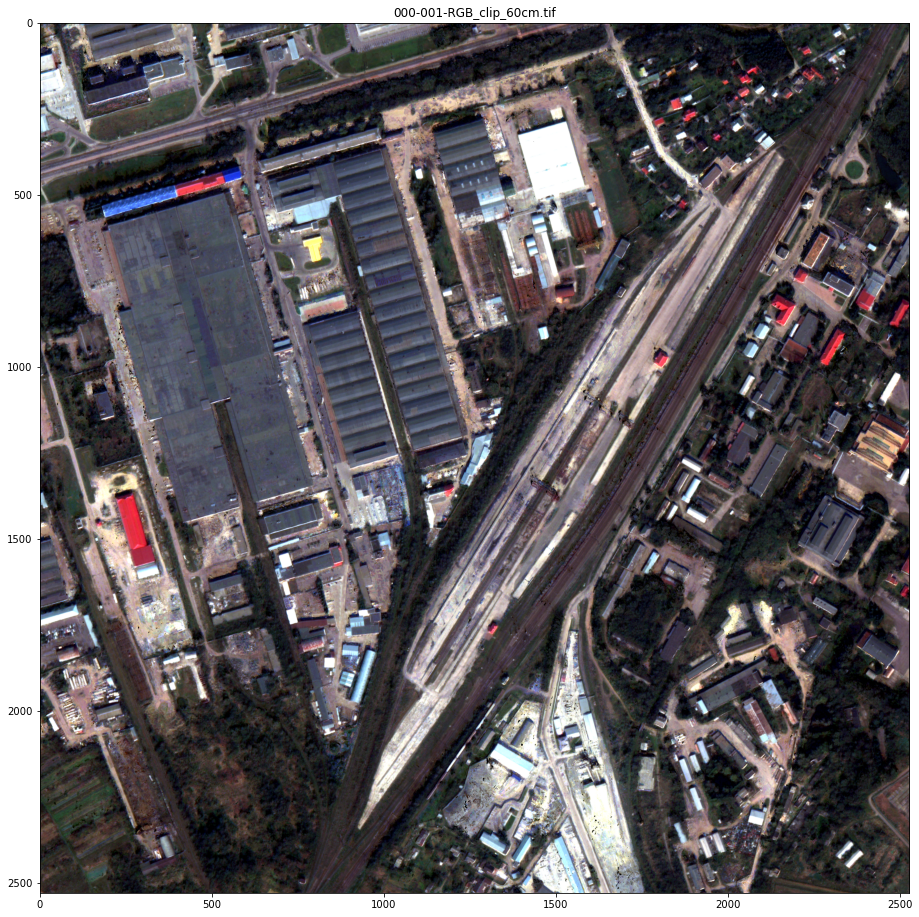

In [9]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im_test.squeeze())
_ = ax.set_title(im_test_name)

-----
## 5. Run Inference

The simplest option is to sipmly run the test.sh script (e.g. ```./test.sh configs/dar_tutorial_cpu.json```) which will execute all of the various inference scripts in series.  For this exercise, we will instead run the individual commands to view what's going on at each step.

### 5.1. 02_eval.py 

The 02_eval.py script applies the trained deep learning model to our testing imagery.  First, we tile the imagery into manageable sizes (~800 x 800 meters or 1300 x 1300 pixels). On windows inference proceeds at ~14 seconds per tile, and the entire process completes in 11 minutes for 25 tiles.

While running, you will see a progress bar something like:
```
20%|████████████████████████                                                                                  | 5/25 [02:27<09:42, 29.13s/it]
```

We will kick off inference

In [10]:
%run -i 02_eval.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Executing inference on the CPU
Run utils.update_config()...
Updated config: {'path_src': '/opt/cresi/cresi', 'path_results_root': '/opt/cresi/results', 'path_data_root': '/opt/cresi/cresi/data', 'train_data_refined_dir_ims': '', 'train_data_refined_dir_masks': '', 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv', 'folds_file_name': 'folds4.csv', 'save_weights_dir': '/opt/cresi/cresi/configs/weights', 'num_folds': 1, 'default_val_perc': 0.2, 'num_channels': 3, 'num_classes': 8, 'network': 'resnet34', 'loss': {'soft_dice': 0.25, 'focal': 0.75}, 'early_stopper_patience': 5, 'nb_epoch': 70, 'test_data_refined_dir': '/opt/cresi/data/final_clips', 'test_results_dir': 'dar_tutorial_cpu', 'folds_save_dir': 'folds', 'tile_df_csv': 'tile_df.csv', 'test_sliced_dir': '/opt/cresi/data/final_clips_sliced', 'slice_x': 1300, 'slice_y': 1300, 'stride_x': 1280, 'stride_y': 1280, 'skeleton_band': 7, 'skeleton_thresh': 0.25, 'min_subgraph_length_pix': 600, 

  0%|                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 25%|████████████████████████████████████▊                                                                                                              | 1/4 [00:23<01:11, 23.76s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 2/4 [00:51<00:52, 26.22s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3/4 [01:15<00:24, 24.95s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:41<00:00, 25.27s/it]

Time to run 1 folds for 4 = 103.49083495140076 seconds


-----
### 5.1. 02_eval.py (continued)

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

mask_pred.shape: (8, 1300, 1300)


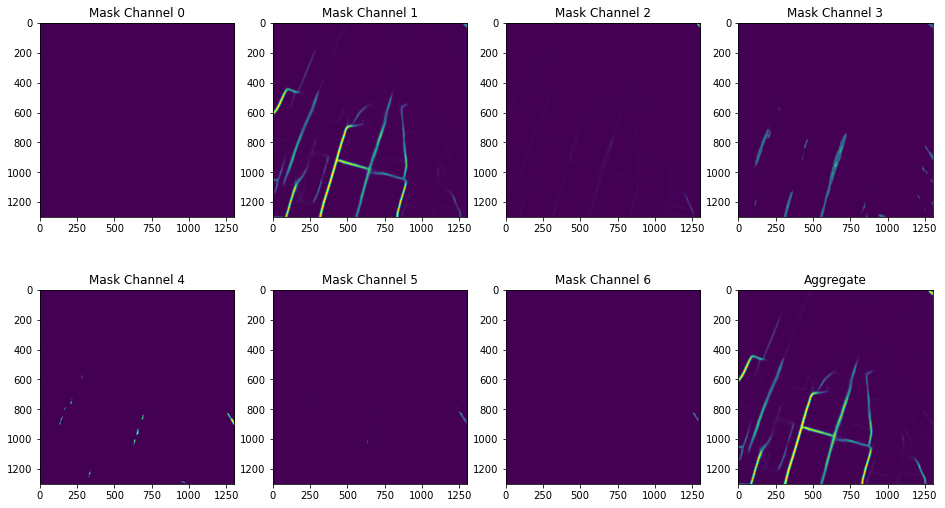

In [11]:
mask_pred_file = [z for z in os.listdir(mask_pred_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

In [12]:
%cd {src_dir}
%run -i 03b_stitch.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Running stitch.py...
post_process_image - w, h: 2528 2528
0 / 4
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 4
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 2528, 2528)
mask_norm.dtype: uint8
Time to run stitch.py and create large masks (and save): 1.9113285541534424 seconds


In [ ]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

-----
### 5.3. 04_skeletonize.py

The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

Steps 1-3 are summarized in the figure below:

<br>
<img src="images/skeletonize.png" alt="Drawing" style="height: 180px;"/>
<br>

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed, and should take ~20 seconds to run.

In [ ]:
%run -i 04_skeletonize.py configs/dar_tutorial_cpu.json

In [ ]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [ ]:
%run -i 05_wkt_to_G.py configs/dar_tutorial_cpu.json 

In [ ]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))